<a href="https://colab.research.google.com/github/subro12/fastbook/blob/master/Feed_forward_self.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [64]:
# Jovian Commit Essentials
# Please retain and execute this cell without modifying the contents for `jovian.commit` to work
!pip install jovian --upgrade -q
import jovian

In [2]:
import torch
import torchvision
from torchvision.datasets import MNIST 
from torchvision.transforms import ToTensor 
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
dataset = MNIST(root='data/',download=True,transform=ToTensor(),train=True)

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw




Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
len(dataset)

60000

image.shape: torch.Size([1, 28, 28])
label: 5


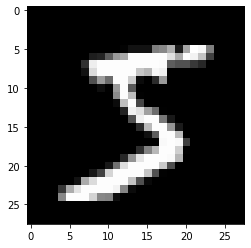

In [5]:
image, label = dataset[0]
print('image.shape:',image.shape)
plt.imshow(image[0],cmap='gray')
print('label:',label)

Another way of showing Image using premute

In [6]:
# Not working need to check this
# understanding squeeze and unsqueeze functions
print(image.unsqueeze(dim=1).shape)
print(image.squeeze().shape)

torch.Size([1, 1, 28, 28])
torch.Size([28, 28])


In [7]:
train_ds,vali_ds = random_split(dataset,[50000,10000])

In [8]:
len(train_ds),len(vali_ds)

(50000, 10000)

As, we have divided into train and validation datasets, lets build dataloaders, using `dataloader` function 

In [9]:
batch_size=128
train_loader = DataLoader(train_ds,batch_size=batch_size,shuffle=True,num_workers=4,pin_memory=True)
val_loader = DataLoader(vali_ds,batch_size=batch_size,num_workers=4,pin_memory=True)

lets try to see a batch of images, how do they look like, lets use `make_grid` function

images.shape: torch.Size([128, 1, 28, 28])


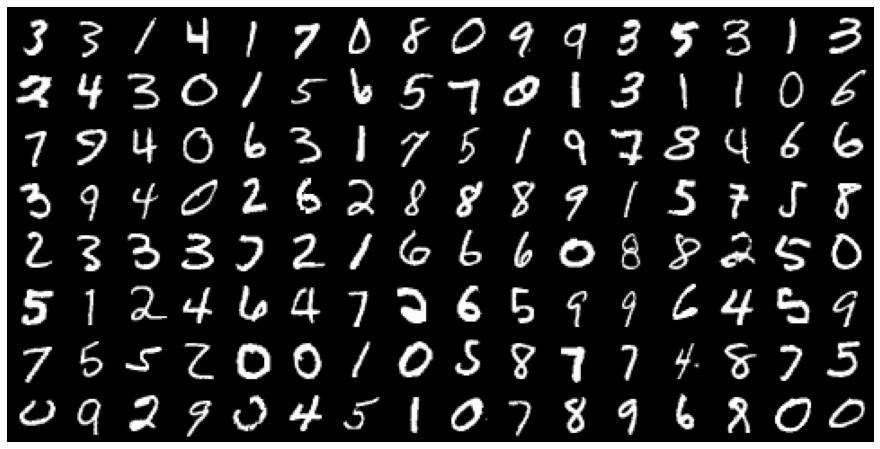

In [10]:
for images, labels in train_loader:
  print('images.shape:',images.shape)
  plt.figure(figsize=(16,8))
  plt.imshow(make_grid(images, nrow=16).permute((1,2,0)))
  plt.axis('off')
  break

But our inputs dimension is `[128,1,28,28]` Lets flatten for one batch 

In [11]:
for images, labels in train_loader:
  print('images.shape: ',images.shape)
  inputs = images.reshape(-1, 28*28)
  print('images.shape: ',inputs.shape)
  break

images.shape:  torch.Size([128, 1, 28, 28])
images.shape:  torch.Size([128, 784])


Lets build our network with 2 layers, 1 is hidden layer another with output layer. So,

In [12]:
# layer1-784x32
# layer2- 32x10
input_size=inputs.shape[-1]
# print(input_size)
hidden_size=32
# fprint(input_size,)
layer1 = nn.Linear(input_size,hidden_size)
# print(layer1.parameters)
# when we created nn.Linear or layer1 it will automatically creates weight and
# bias for the layer, So, you can print them as below
# print(layer1.weight,layer1.bias)

In [13]:
layer1_outputs = inputs @ layer1.weight.t() + layer1.bias
print(layer1_outputs.shape)

torch.Size([128, 32])


In [14]:
layer1_outputs_direct = layer1(inputs)
print(layer1_outputs_direct.shape)

torch.Size([128, 32])


we can compare both using` torch.allclose`

In [15]:
torch.allclose(layer1_outputs, layer1_outputs_direct,1e-3)

True

Looks both are same, lets, apply `relu` function on layer1 outputs to create non-linearity between layers and send to layer2.

In [16]:
relu_outputs = F.relu(layer1_outputs)

In [17]:
output_size=10
layer2 = nn.Linear(hidden_size,output_size)

In [18]:
print(layer2.weight.shape,layer2.bias)
print(relu_outputs.shape)

torch.Size([10, 32]) Parameter containing:
tensor([-0.0756, -0.1067,  0.0199,  0.0788, -0.0775, -0.0608,  0.1120, -0.0618,
        -0.1237,  0.0652], requires_grad=True)
torch.Size([128, 32])


In [19]:
layer2_direct_outputs = relu_outputs @ layer2.weight.t() + layer2.bias

In [20]:
layer2_outputs = layer2(relu_outputs)

In [21]:
torch.allclose(layer2_outputs, layer2_direct_outputs,1e-3)

True

In [22]:
class MnistModel(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super().__init__()
    self.linear1 = nn.Linear(input_size,hidden_size)

    self.linear2 = nn.Linear(hidden_size, output_size)

  def forward(self, xb):
    xb = xb.view(xb.size(0), -1)
    out = self.linear1(xb)
    out = F.relu(out)
    out = self.linear2(out)
    return out

  def training_step(self, xb):
    """ this is to calculate training error and training accuracy of the data """
    images, labels = xb
    out = self(images)
    loss = F.cross_entropy(out,labels)
    return loss

  def validation_step(self, xb):
    images, labels = xb
    out = self(images)
    loss = F.cross_entropy(out, labels)
    acc = accuracy(out, labels)
    return {'val_loss': loss, 'val_accuracy': acc}

  def validation_epoch_end(self, outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()
    batch_acc = [x['val_accuracy'] for x in outputs]
    epoch_acc = torch.stack(batch_acc).mean()
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

  def epoch_end(self, epoch, result):
    print("Epoch: {}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'],result['val_acc']))





In [23]:
# rather than calculating softmax, we are taking the one which has highest output
def accuracy(out,labels):
  _, preds = torch.max(out,dim=1)
  
  return torch.tensor(torch.sum(preds==labels).item() / len(preds))

In [24]:
input_size = 784
hidden_size = 32
output_size = 10

In [25]:
model = MnistModel(input_size,hidden_size,output_size)

In [26]:
for x in model.parameters():
  print(x.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


lets check accuracy for one batch.


Loss: 2.291686773300171
torch.Size([28, 28])
outputs.shape : torch.Size([128, 10])
Sample outputs:  tensor([ 0.0253,  0.1681,  0.0502,  0.0909,  0.2053, -0.0079,  0.1773,  0.1060,
        -0.0736, -0.1795], grad_fn=<SelectBackward>)


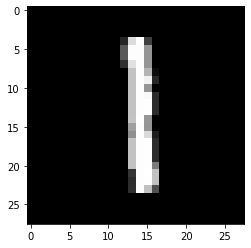

In [27]:
for images,labels in train_loader:
  outputs = model(images)
  loss = F.cross_entropy(outputs,labels)
  print('Loss:',loss.item())
  print(images[0][0].shape)
  plt.imshow(images[0][0],cmap='gray')
  break

# less check loss 
print('outputs.shape :',outputs.shape)
print('Sample outputs: ',outputs[0])


Let's move all our code and data to `GPU`

In [28]:
torch.cuda.is_available()

True

In [29]:
def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  return torch.device('cpu')

In [30]:
device = get_default_device()
print(device)

cuda


In [31]:
def to_device(data, device):
  if isinstance(data, (list,tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

lets check `to_device` method for one batch, and check it is working properly or not

In [32]:
for images, lables in train_loader:
  print(images.shape, images.device)
  images = to_device(images, device)
  print(images.device)
  break

torch.Size([128, 1, 28, 28]) cpu
cuda:0


In [33]:
class DeviceDataLoader():
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    for b in self.dl:
      yield (to_device(b, self.device))

  def __len__(self):
    return len(self.dl)


In [34]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

In [35]:
def evaluate(model, val_loader):
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

In [36]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
  history = []
  optimizer = opt_func(model.parameters(), lr)
  for epoch in range(epochs):
    for batch in train_loader:
      loss = model.training_step(batch)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    
    result = evaluate(model, val_loader)
    model.epoch_end(epoch, result)
    history.append(result)
  return history

In [37]:
model = MnistModel(input_size, hidden_size, output_size)
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [38]:
history = [evaluate(model,val_loader)]
history

[{'val_acc': 0.1514042764902115, 'val_loss': 2.3062262535095215}]

In [39]:
history += fit(10, 0.1, model, train_loader, val_loader) 

Epoch: 0, val_loss: 0.3730, val_acc: 0.8941
Epoch: 1, val_loss: 0.3042, val_acc: 0.9159
Epoch: 2, val_loss: 0.2665, val_acc: 0.9241
Epoch: 3, val_loss: 0.2421, val_acc: 0.9311
Epoch: 4, val_loss: 0.2271, val_acc: 0.9376
Epoch: 5, val_loss: 0.2123, val_acc: 0.9412
Epoch: 6, val_loss: 0.2012, val_acc: 0.9429
Epoch: 7, val_loss: 0.1902, val_acc: 0.9455
Epoch: 8, val_loss: 0.1816, val_acc: 0.9489
Epoch: 9, val_loss: 0.1750, val_acc: 0.9499


In [40]:
history += fit(30, 0.1, model, train_loader, val_loader)

Epoch: 0, val_loss: 0.1697, val_acc: 0.9507
Epoch: 1, val_loss: 0.1648, val_acc: 0.9538
Epoch: 2, val_loss: 0.1596, val_acc: 0.9537
Epoch: 3, val_loss: 0.1556, val_acc: 0.9541
Epoch: 4, val_loss: 0.1534, val_acc: 0.9559
Epoch: 5, val_loss: 0.1575, val_acc: 0.9538
Epoch: 6, val_loss: 0.1456, val_acc: 0.9574
Epoch: 7, val_loss: 0.1459, val_acc: 0.9582
Epoch: 8, val_loss: 0.1433, val_acc: 0.9592
Epoch: 9, val_loss: 0.1420, val_acc: 0.9593
Epoch: 10, val_loss: 0.1407, val_acc: 0.9607
Epoch: 11, val_loss: 0.1392, val_acc: 0.9598
Epoch: 12, val_loss: 0.1377, val_acc: 0.9604
Epoch: 13, val_loss: 0.1327, val_acc: 0.9609
Epoch: 14, val_loss: 0.1312, val_acc: 0.9632
Epoch: 15, val_loss: 0.1308, val_acc: 0.9626
Epoch: 16, val_loss: 0.1273, val_acc: 0.9642
Epoch: 17, val_loss: 0.1275, val_acc: 0.9634
Epoch: 18, val_loss: 0.1254, val_acc: 0.9645
Epoch: 19, val_loss: 0.1261, val_acc: 0.9625
Epoch: 20, val_loss: 0.1287, val_acc: 0.9648
Epoch: 21, val_loss: 0.1284, val_acc: 0.9638
Epoch: 22, val_loss:

we got 96% accuracy, lets plot graphs


In [52]:
history

[{'val_acc': 0.1514042764902115, 'val_loss': 2.3062262535095215},
 {'val_acc': 0.8940862417221069, 'val_loss': 0.37295588850975037},
 {'val_acc': 0.9159414768218994, 'val_loss': 0.30417102575302124},
 {'val_acc': 0.9241495132446289, 'val_loss': 0.2665282189846039},
 {'val_acc': 0.9310719966888428, 'val_loss': 0.24213804304599762},
 {'val_acc': 0.9375988841056824, 'val_loss': 0.22709931433200836},
 {'val_acc': 0.9411590099334717, 'val_loss': 0.21232134103775024},
 {'val_acc': 0.9429391026496887, 'val_loss': 0.20116868615150452},
 {'val_acc': 0.9455102682113647, 'val_loss': 0.1902412325143814},
 {'val_acc': 0.9488726258277893, 'val_loss': 0.18155339360237122},
 {'val_acc': 0.9498615264892578, 'val_loss': 0.17504248023033142},
 {'val_acc': 0.9506527185440063, 'val_loss': 0.1697186529636383},
 {'val_acc': 0.9538172483444214, 'val_loss': 0.16481006145477295},
 {'val_acc': 0.953718364238739, 'val_loss': 0.15955740213394165},
 {'val_acc': 0.9541139006614685, 'val_loss': 0.1555585116147995},
 

Text(0.5, 1.0, 'Loss Vs Epochs')

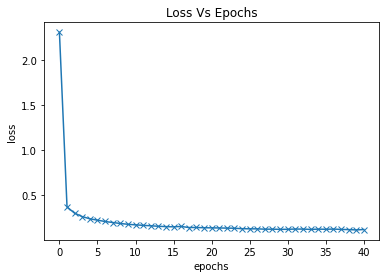

In [53]:
losses = [x['val_loss'] for x in history]
plt.plot(losses,'-x')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Loss Vs Epochs')

Text(0.5, 1.0, 'Accuracy Vs Epochs')

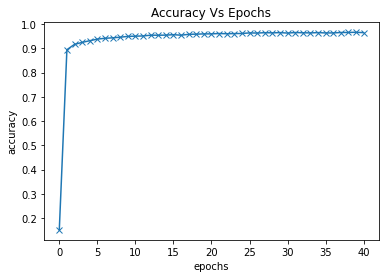

In [54]:
accuracy = [x['val_acc'] for x in history]
plt.plot(accuracy,'-x')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Accuracy Vs Epochs')

TEst with Indivudual images

In [56]:
test_data = MNIST(root='data/', train=False, transform=ToTensor(),download=True)

In [57]:
len(test_data)

10000

In [58]:
def predict_image(img,model):
  xb = to_device(img.unsqueeze(0),device)
  yb = model(xb)
  _, preds = torch.max(yb, dim=1)
  return preds[0].item()

predicted label : 7


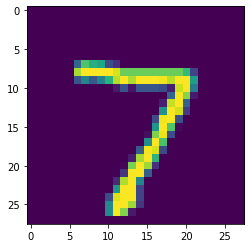

In [59]:
img, label = test_data[0]
plt.imshow(img[0])
pred_label = predict_image(img, model)
print('predicted label :',pred_label)

predicted label : 2


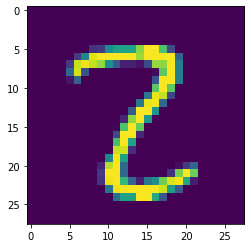

In [60]:
img, label = test_data[1839]
plt.imshow(img[0])
pred_label = predict_image(img, model)
print('predicted label :',pred_label)

predicted label : 9


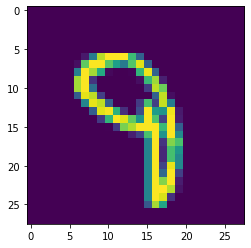

In [61]:
img, label = test_data[193]
plt.imshow(img[0])
pred_label = predict_image(img, model)
print('predicted label :',pred_label)

In [62]:
test_loader = DeviceDataLoader(DataLoader(test_data, batch_size=256), device)

In [63]:
# result = evaluate()
result = evaluate(model, test_loader)

TypeError: ignored

In [66]:
jovian.commit(project='04-feedforward-nn-self', environment=None)

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Committed successfully! https://jovian.ai/subbarao-athmuri/04-feedforward-nn-self


'https://jovian.ai/subbarao-athmuri/04-feedforward-nn-self'